<a href="https://colab.research.google.com/github/monika-bronska/japanese-formality-classifier/blob/main/BERT_JESC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare the environment and load the necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
!pip3 install -q tensorflow_gpu==2.1.0

     |████████████████████████████████| 421.8 MB 4.7 kB/s 
     |████████████████████████████████| 3.8 MB 52.6 MB/s 
     |████████████████████████████████| 448 kB 78.4 MB/s 
     |████████████████████████████████| 50 kB 8.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.1.1 which is incompatible.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.


In [5]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [6]:
!pip3 install -q ktrain

     |████████████████████████████████| 25.3 MB 566 kB/s 
     |████████████████████████████████| 22.3 MB 79.2 MB/s 
     |████████████████████████████████| 981 kB 76.6 MB/s 
     |████████████████████████████████| 263 kB 76.4 MB/s 
     |████████████████████████████████| 2.8 MB 57.2 MB/s 
     |████████████████████████████████| 1.2 MB 65.3 MB/s 
     |████████████████████████████████| 468 kB 65.1 MB/s 
     |████████████████████████████████| 3.3 MB 47.9 MB/s 
     |████████████████████████████████| 77 kB 8.3 MB/s 
     |████████████████████████████████| 596 kB 77.9 MB/s 
     |████████████████████████████████| 895 kB 74.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


## Load the dataset for fine-tuning the model

In [51]:
import pandas as pd

with open("/content/drive/MyDrive/Colab Notebooks/Model/JESC/tuning_train.csv") as file:
    train = pd.read_csv(file)

print(train.head(30))

    Unnamed: 0                   jp_sentence     label
0      1533289            落ち着いて 私のアドバイスを忘れずに  informal
1      1247871                  私 魔女にはなりたくない  informal
2       950993     翌日の4時04分に 404ドルもの賞金を渡しました    polite
3      1736253                  大丈夫ですよ。 行こう。    polite
4      2185184                  5年もやってれば慣れます    polite
5      1537257                     自分の電気ですから    polite
6      1930911              お...おはよう...ございます    polite
7      2402529                判ったよ 静かに、黙るんだ!  informal
8      2144582        5つの強みを知るための有効なテストがあります    polite
9      1823023      あの... シャワー浴びてる 女性がいますけど。    polite
10     1537836                       20分前は3+  informal
11     2050660                     トントン叩くのです    polite
12     1450758            場所によっては 火星よりも寒いのです    polite
13      293247          検事に話しといたわ なかった事にするって  informal
14     2185524                    ごくかすかな音でした    polite
15      447746                あなたにしか話していないのよ  informal
16      752718             指示されてすることでは ない点です    polite
17      41

In [52]:
x_train = train['jp_sentence'].tolist()
y_train = train['label'].tolist()

In [53]:
with open("/content/drive/MyDrive/Colab Notebooks/Model/JESC/validation.csv") as file:
    dev = pd.read_csv(file)

print(dev.head())

   Unnamed: 0              jp_sentence     label
0         405               地球にもたらされた。  informal
1        1190               うるせーな 返せよッ  informal
2        1132         わからないわ 私は心を読めないの  informal
3         731  曲は完璧なんだよ。 作り直す必要なんかねえよ。  informal
4        1754                座るつもりはない!  informal


In [54]:
x_dev = dev['jp_sentence'].tolist()
y_dev = dev['label'].tolist()

## Load the libraries required by Tohoku BERT version

In [11]:
pip install fugashi[unidic-lite]

     |████████████████████████████████| 568 kB 4.0 MB/s 
     |████████████████████████████████| 47.4 MB 1.3 MB/s 
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658836 sha256=d1cf20677d8c80d64e758f9b85915c6a89d4380cfc73b70dc4b16af647acec8b
  Stored in directory: /root/.cache/pip/wheels/de/69/b1/112140b599f2b13f609d485a99e357ba68df194d2079c5b1a2
Successfully built unidic-lite


In [12]:
pip install ipadic

     |████████████████████████████████| 13.4 MB 3.5 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=096caade50785a19872a4a4990d794aca5698649671b0f0c6c3900c0ece8890a
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic


In [13]:
import ktrain
from ktrain import text

## Hyper-Parameter Tuning

In [55]:
MODEL_NAME = 'cl-tohoku/bert-base-japanese-v2'
t = text.Transformer(MODEL_NAME, maxlen=128, classes=['polite', 'informal'])
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_dev, y_dev)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:422: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: ja


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:625: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: ja


**1. Estimate optimal learning rate**

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
8333/8333 [==============================] - 1509s 178ms/step - loss: 0.3255 - accuracy: 0.8068
Epoch 2/2
8333/8333 [==============================] - 31s 4ms/step - loss: 0.8308 - accuracy: 0.5066


done.
Visually inspect loss plot and select learning rate associated with falling loss


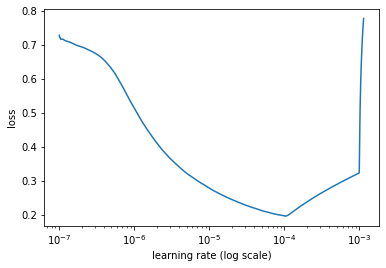

In [56]:
learner.lr_find(show_plot=True, max_epochs=2)

**2. Test the performance of chosen learning rates and fitting methods**

**a) Fitting the model with static learning rate of 0.0005 with 2 epochs**

In [58]:
MODEL_NAME = 'cl-tohoku/bert-base-japanese-v2'
t = text.Transformer(MODEL_NAME, maxlen=128, classes=['polite', 'informal'])
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_dev, y_dev)
model = t.get_classifier()
learner_1 = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:422: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: ja


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:625: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: ja


In [59]:
learner_1.fit(4e-5, 2)

Epoch 1/2
8334/8334 [==============================] - 1512s 179ms/step - loss: 0.0253 - accuracy: 0.9953 - val_loss: 0.0140 - val_accuracy: 0.9985
Epoch 2/2
8334/8334 [==============================] - 1505s 180ms/step - loss: 0.2972 - accuracy: 0.7956 - val_loss: 0.7220 - val_accuracy: 0.1840


*The results indicate that the model is underfitting and different learning rate should be tested.*

**b) Fitting the model with static learning rate of 0.00005 with 2 epochs**

In [63]:
MODEL_NAME = 'cl-tohoku/bert-base-japanese-v2'
t = text.Transformer(MODEL_NAME, maxlen=128, classes=['polite', 'informal'])
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_dev, y_dev)
model = t.get_classifier()
learner_2 = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:422: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: ja


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:625: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: ja


In [64]:
learner_2.fit(5e-5, 2)

Epoch 1/2
8334/8334 [==============================] - 1509s 178ms/step - loss: 0.2203 - accuracy: 0.8664 - val_loss: 0.7878 - val_accuracy: 0.1840
Epoch 2/2
8334/8334 [==============================] - 1499s 179ms/step - loss: 0.6987 - accuracy: 0.4991 - val_loss: 0.6889 - val_accuracy: 0.8160


*Higher loss on the validation set indicates that the model is overfitting. The number of epochs also needs increasing for improved performance and more accurate results.*

**c) Fitting the model with 1cycle learning rate policy with 3 epochs**

In [65]:
MODEL_NAME = 'cl-tohoku/bert-base-japanese-v2'
t = text.Transformer(MODEL_NAME, maxlen=128, classes=['polite', 'informal'])
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_dev, y_dev)
model = t.get_classifier()
learner_3 = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:422: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: ja


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:625: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: ja


In [66]:
learner_3.fit_onecycle(5e-5, 3)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/3
8334/8334 [==============================] - 1527s 180ms/step - loss: 0.0337 - accuracy: 0.9915 - val_loss: 0.0305 - val_accuracy: 0.9955
Epoch 2/3
8334/8334 [==============================] - 1517s 181ms/step - loss: 0.0360 - accuracy: 0.9931 - val_loss: 0.0305 - val_accuracy: 0.9960
Epoch 3/3
8334/8334 [==============================] - 1509s 180ms/step - loss: 0.0302 - accuracy: 0.9951 - val_loss: 0.0287 - val_accuracy: 0.9960


Model's performance significantly improved using onecycle fitting method over static learning rate.

**2. Max Length**

In [ ]:
# Error output for higher maxlen 
#MODEL_NAME = 'cl-tohoku/bert-base-japanese-v2'
#t = text.Transformer(MODEL_NAME, maxlen=512, classes=['polite', 'informal'])
#trn = t.preprocess_train(x_train, y_train)
#val = t.preprocess_test(x_dev, y_dev)
#model = t.get_classifier()
#learner_4 = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

In [ ]:
# Error output for higher maxlen - ResourceExhaustedError
#learner_4.fit_onecycle(5e-5, 3)



**2. Batch Size**

In [69]:
# change batch_size value from 6 to 12
MODEL_NAME = 'cl-tohoku/bert-base-japanese-v2'
t = text.Transformer(MODEL_NAME, maxlen=128, classes=['polite', 'informal'])
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_dev, y_dev)
model = t.get_classifier()
learner_5 = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=12)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:422: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: ja


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:625: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: ja


In [70]:
learner_5.fit_onecycle(5e-5, 3)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/3
4167/4167 [==============================] - 1374s 324ms/step - loss: 0.0323 - accuracy: 0.9909 - val_loss: 0.0044 - val_accuracy: 0.9995
Epoch 2/3
4167/4167 [==============================] - 1360s 324ms/step - loss: 0.0325 - accuracy: 0.9919 - val_loss: 0.0083 - val_accuracy: 0.9990
Epoch 3/3
4167/4167 [==============================] - 1363s 325ms/step - loss: 0.0122 - accuracy: 0.9982 - val_loss: 0.0081 - val_accuracy: 0.9990


In [73]:
# change batch_size value from 12 to 32 - resulted in error as 32 was too high
# update batch_size to 24
MODEL_NAME = 'cl-tohoku/bert-base-japanese-v2'
t = text.Transformer(MODEL_NAME, maxlen=128, classes=['polite', 'informal'])
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_dev, y_dev)
model = t.get_classifier()
learner_6 = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=24)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:422: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: ja


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:625: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: ja


In [74]:
learner_6.fit_onecycle(5e-5, 3)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/3


ResourceExhaustedError: ignored